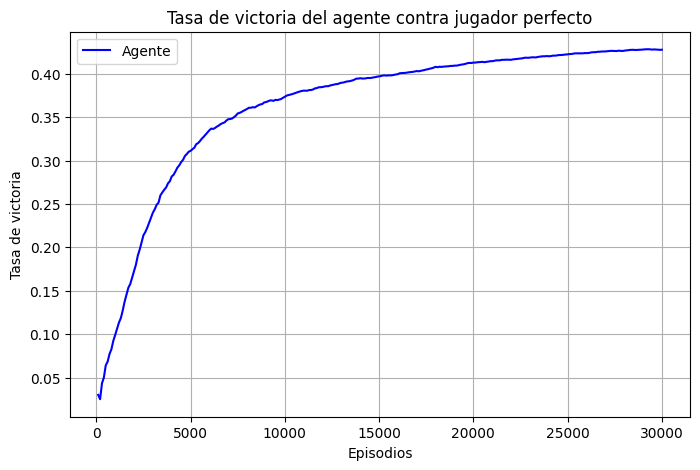

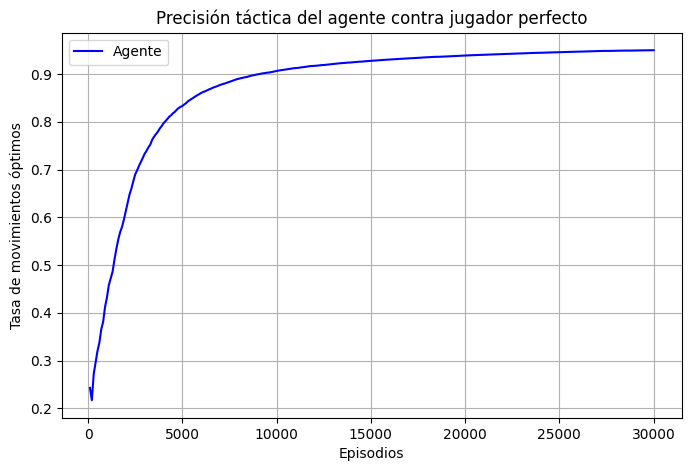

In [2]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# ----------------------------
# Parámetros del entorno
# ----------------------------
NUM_HEAPS = 3
MAX_HEAP_SIZE = 5
EPISODES = 30000
ALPHA = 0.2
GAMMA = 0.6
EPSILON_START = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99

# ----------------------------
# Funciones auxiliares
# ----------------------------
def get_possible_actions(state):
    actions = []
    for i, heap in enumerate(state):
        for amt in range(1, heap + 1):
            actions.append((i, amt))
    return actions

def apply_action(state, action):
    heap_idx, remove_amt = action
    state = list(state)
    state[heap_idx] -= remove_amt
    return tuple(state)

def is_terminal(state):
    return all(heap == 0 for heap in state)

def choose_agent_action(state, Q, epsilon):
    actions = get_possible_actions(state)
    if not actions:
        return None
    if random.random() < epsilon:
        return random.choice(actions)
    q_vals = [Q[(state, a)] for a in actions]
    max_q = max(q_vals)
    best_actions = [a for a, q in zip(actions, q_vals) if q == max_q]
    return random.choice(best_actions)

def xor_sum(state):
    result = 0
    for heap in state:
        result ^= heap
    return result

def choose_perfect_action(state):
    actions = get_possible_actions(state)
    if xor_sum(state) == 0:
        return random.choice(actions)
    for action in actions:
        if xor_sum(apply_action(state, action)) == 0:
            return action
    return random.choice(actions)  # fallback, shouldn't happen

# ----------------------------
# Inicialización de Q-learning
# ----------------------------
Q = defaultdict(float)
epsilon = EPSILON_START

win_counts = 0
win_rates = []
optimal_opportunities = 0
optimal_moves = 0
optimal_move_rates = []

# ----------------------------
# Entrenamiento con agente vs jugador perfecto
# ----------------------------
for episode in range(EPISODES):
    state = tuple(random.randint(1, MAX_HEAP_SIZE) for _ in range(NUM_HEAPS))
    player_turn = random.randint(0, 1)  # 0: agente, 1: jugador perfecto

    prev_state = None
    prev_action = None

    while not is_terminal(state):
        actions = get_possible_actions(state)
        xor_before = xor_sum(state)
        good_move_available = any(xor_sum(apply_action(state, a)) == 0 for a in actions)

        if player_turn == 0:
            if xor_before != 0 and good_move_available:
                optimal_opportunities += 1

            action = choose_agent_action(state, Q, epsilon)
            if action is None:
                break
            next_state = apply_action(state, action)

            if xor_before != 0 and xor_sum(next_state) == 0:
                optimal_moves += 1

            # Actualizar Q
            if prev_state is not None and prev_action is not None:
                reward = 0
                next_actions = get_possible_actions(state)
                max_next_q = max([Q[(state, a)] for a in next_actions], default=0)
                Q[(prev_state, prev_action)] += ALPHA * (reward + GAMMA * max_next_q - Q[(prev_state, prev_action)])

            prev_state = state
            prev_action = action
            state = next_state

            if is_terminal(state):
                win_counts += 1
                Q[(prev_state, prev_action)] += ALPHA * (1 - Q[(prev_state, prev_action)])
                break
        else:
            action = choose_perfect_action(state)
            state = apply_action(state, action)

            if is_terminal(state):
                # El jugador perfecto gana
                if prev_state is not None and prev_action is not None:
                    Q[(prev_state, prev_action)] += ALPHA * (-1 - Q[(prev_state, prev_action)])
                break

        player_turn = 1 - player_turn

    # Decaer epsilon
    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    # Métricas cada 100 episodios
    if (episode + 1) % 100 == 0:
        win_rates.append(win_counts / (episode + 1))
        if optimal_opportunities == 0:
            optimal_move_rates.append(0)
        else:
            optimal_move_rates.append(optimal_moves / optimal_opportunities)

# ----------------------------
# Visualización
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(np.arange(100, EPISODES + 1, 100), win_rates, label='Agente', color='blue')
plt.xlabel("Episodios")
plt.ylabel("Tasa de victoria")
plt.title("Tasa de victoria del agente contra jugador perfecto")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(100, EPISODES + 1, 100), optimal_move_rates, label='Agente', color='blue')
plt.xlabel("Episodios")
plt.ylabel("Tasa de movimientos óptimos")
plt.title("Precisión táctica del agente contra jugador perfecto")
plt.grid(True)
plt.legend()
plt.show()





